In [4]:
import torch
from transformers import CLIPModel, CLIPProcessor
from torch.optim import AdamW  # Use PyTorch's native AdamW

# Device setup (Ensure CUDA usage)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Define Combiner Network
class Combiner(torch.nn.Module):
    def __init__(self, feature_dim, projection_dim=512, hidden_dim=1024, dropout_rate=0.5):
        super(Combiner, self).__init__()
        self.fc1 = torch.nn.Linear(feature_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.fc2 = torch.nn.Linear(hidden_dim, projection_dim)
        self.relu = torch.nn.ReLU()

    def forward(self, features):  # Fixed typo: 'fesatures' -> 'features'
        combined = self.relu(self.fc1(features))  # Fixed typo
        combined = self.dropout(combined)
        return self.fc2(combined)

# Define Similarity Head
class SimilarityHead(torch.nn.Module):
    def __init__(self, input_dim):
        super(SimilarityHead, self).__init__()
        self.similarity_fc = torch.nn.Linear(input_dim, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, features1, features2):
        diff = features1 - features2
        similarity_score = self.sigmoid(self.similarity_fc(diff))
        return similarity_score

# Get feature dimensions
feature_dim = model.text_projection.weight.shape[1]
combiner = Combiner(feature_dim).to(device)
similarity_head = SimilarityHead(512).to(device)

# Define optimizer & scheduler (aligned with MoCo)
optimizer = AdamW(
    list(model.parameters()) + list(combiner.parameters()) + list(similarity_head.parameters()),
    lr=1e-1,  # Same as MoCo
    weight_decay=0.1,
    fused=True  # Fused AdamW for faster training (only works with PyTorch's native AdamW)
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)  # Same as MoCo

Using device: cuda


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [6]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

# Define transformations (same normalization as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

class ReferenceImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Collect all image paths from the folder (adjust extensions as needed)
        self.image_paths = [os.path.join(root_dir, fname) 
                            for fname in os.listdir(root_dir) 
                            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path  # return path for reference if needed

# Update the path below to the location of your reference images
reference_images_path = "/kaggle/input/refs-50k-19"  
reference_dataset = ReferenceImageDataset(reference_images_path, transform=transform)
dataloader = DataLoader(reference_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

print(f"Loaded {len(reference_dataset)} reference images.")


Loaded 50000 reference images.


In [16]:
import torch
import numpy as np
from torch.nn.functional import cosine_similarity
from PIL import Image

# Load your query image (update the path accordingly)
query_image_path = "/kaggle/input/test-image/Q50434.jpg"  # Change this to your query image path
query_img = Image.open(query_image_path).convert("RGB")

# Preprocess the query image using the CLIP processor (assuming 'processor' is already loaded)
query_inputs = processor(images=query_img, return_tensors="pt").to(device)

# Compute the query image feature (extract tensor if needed)
with torch.no_grad():
    query_output = model.get_image_features(pixel_values=query_inputs["pixel_values"])
    query_feature = query_output.pooler_output if hasattr(query_output, "pooler_output") else query_output
    query_feature = torch.nn.functional.normalize(query_feature, dim=-1)

# Retrieve the most similar image from the reference dataset
max_sim = -1.0
best_ref_tensor = None
best_ref_path = None

for images, paths in dataloader:
    images = images.to(device)
    with torch.no_grad():
        ref_output = model.get_image_features(pixel_values=images)
        ref_features = ref_output.pooler_output if hasattr(ref_output, "pooler_output") else ref_output
        ref_features = torch.nn.functional.normalize(ref_features, dim=-1)
    # Compute cosine similarity between query feature and each reference image in the batch
    sims = cosine_similarity(query_feature, ref_features)
    batch_max, idx = sims.max(dim=0)
    if batch_max.item() > max_sim:
        max_sim = batch_max.item()
        best_ref_tensor = images[idx]
        best_ref_path = paths[idx]

print(f"Maximum similarity score: {max_sim:.4f}")
print(f"Most similar image path: {best_ref_path}")

# Convert the best reference tensor to an image for visualization
best_ref_img = best_ref_tensor.cpu().permute(1, 2, 0).numpy()
# Undo normalization (assuming same mean and std as used during training)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
best_ref_img = best_ref_img * std + mean
best_ref_img = np.clip(best_ref_img, 0, 1)


Maximum similarity score: 0.7537
Most similar image path: /kaggle/input/refs-50k-19/R973166.jpg


In [9]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.3 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39647 sha256=310897e798dd31cfcb586e4f218e3ce6ff117df08be15240f580ec5fe8c148d9
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


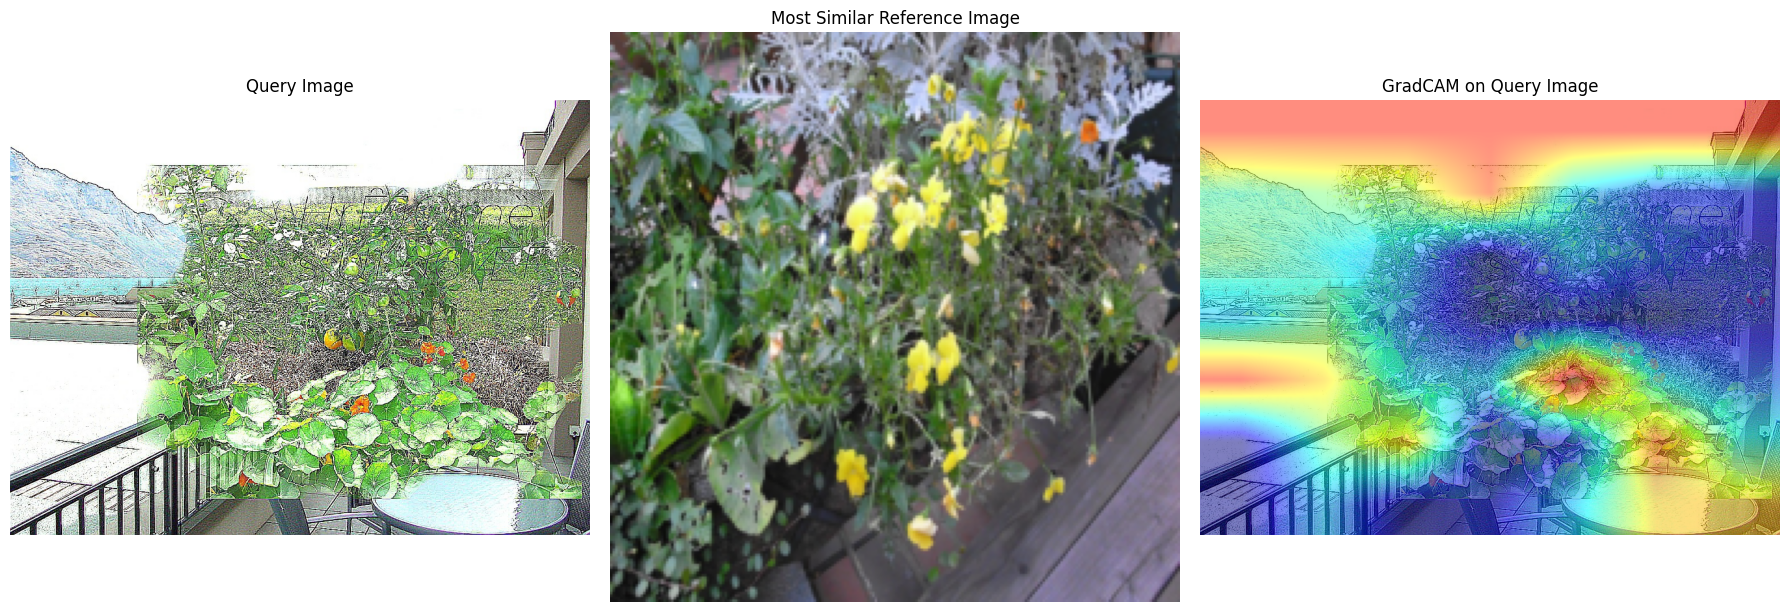

In [22]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Use the patch embedding layer directly as the target layer
target_layer = model.vision_model.embeddings.patch_embedding

# Create the GradCAM object using the custom vision model (assuming you already wrapped it)
cam = GradCAM(model=custom_vision_model, target_layers=[target_layer])

# Run GradCAM on the query image
query_pixel_values = query_inputs["pixel_values"]
grayscale_cam = cam(input_tensor=query_pixel_values)
grayscale_cam = grayscale_cam[0, :]  # Use the heatmap for the first image in the batch

# Prepare the original query image for overlay (normalized to [0,1])
query_img_np = np.array(query_img).astype(np.float32) / 255.0

# Resize the heatmap to match the query image dimensions
h, w, _ = query_img_np.shape
grayscale_cam_resized = cv2.resize(grayscale_cam, (w, h))

# Generate the CAM overlay using the resized heatmap
cam_overlay = show_cam_on_image(query_img_np, grayscale_cam_resized, use_rgb=True)

# Visualization: display the query image, most similar reference image, and CAM overlay
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(query_img)
ax[0].set_title("Query Image")
ax[0].axis("off")

ax[1].imshow(best_ref_img)
ax[1].set_title("Most Similar Reference Image")
ax[1].axis("off")

ax[2].imshow(cam_overlay)
ax[2].set_title("GradCAM on Query Image")
ax[2].axis("off")

plt.tight_layout()
plt.show()
